# Chargement des données préparées

In [21]:
import pandas as pd

# Charger le dataset final
df = pd.read_csv(r"C:\Users\STEVE\desktop\house-price-prediction-france\data\feature_engineered/2024\feature_engineered.csv.gz" ,compression="gzip", sep=",", low_memory=False)
df[["type_local_Local industriel. commercial ou assimilé", "type_local_Maison"]] = df[["type_local_Local industriel. commercial ou assimilé", "type_local_Maison"]].astype(int)

# Vérifier les premières lignes
df.head()

,valeur_fonciere,surface_reelle_bati,nombre_pieces_principales,code_departement,latitude,longitude,type_local_Local industriel. commercial ou assimilé,type_local_Maison,valeur_fonciere_log,surface_log
0,329500.0,89,4,01,46.332212,6.058695,0,0,12.705335,4.499810
1,94500.0,32,2,01,45.904292,5.348768,0,0,11.456366,3.496508
2,94500.0,74,3,01,45.904292,5.348768,0,0,11.456366,4.317488
3,220000.0,40,1,01,46.020243,5.461880,0,1,12.301387,3.713572
4,220000.0,80,2,01,46.020164,5.461676,0,1,12.301387,4.394449


# Séparation des variables cibles et explicatives

In [48]:
# Séparation des features et de la target

X = df.drop(columns=["valeur_fonciere","valeur_fonciere_log","surface_reelle_bati"])
y = df["valeur_fonciere_log"]

# Division du dataset en train (80%) et test (20%)

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Train size: {X_train.shape}, Test size: {X_test.shape}")

print(X_train.dtypes)
print(X_train.head())


Train size: (375084, 8), Test size: (93772, 8)
nombre_pieces_principales                                int64
code_departement                                        object
latitude                                               float64
longitude                                              float64
type_local_Local industriel. commercial ou assimilé      int64
type_local_Maison                                        int64
surface_log                                            float64
densite_pieces                                         float64
dtype: object
        nombre_pieces_principales code_departement   latitude  longitude  \
173756                          1               38  45.122964   5.875627   
34002                           2               09  42.907638   1.396422   
158005                          2               34  43.278229   3.491052   
145495                          5               33  45.311421  -0.934471   
386522                          4               84  43.

In [49]:
import pandas as pd

X_train = pd.get_dummies(X_train, columns=['code_departement'], drop_first=True)
X_test = pd.get_dummies(X_test, columns=['code_departement'], drop_first=True)


# Entrainnement du premier modele (Regression lineaire)

In [50]:
from sklearn.linear_model import LinearRegression

# Initialisation du modèle
model = LinearRegression()

# Entraînement du modèle
model.fit(X_train, y_train)

# Prédictions
y_pred = model.predict(X_test)

# Evaluation du modèle (MSE, MAE, RMSE)

In [52]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Calcul des métriques
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"🔹 MAE : {mae:.2f} €")
print(f"🔹 RMSE : {rmse:.2f} €")
print(f"🔹 R² : {r2:.3f}")

🔹 MAE : 0.58 €
🔹 RMSE : 0.85 €
🔹 R² : 0.272


# Test d'autres modeles

## Random Forest

In [55]:
from sklearn.ensemble import RandomForestRegressor

# Initialisation et entraînement du modèle
rf_model = RandomForestRegressor(n_estimators=500, max_depth=15, min_samples_split=5, min_samples_leaf=2, random_state=42)
rf_model.fit(X_train, y_train)

# Prédictions
y_pred_rf = rf_model.predict(X_test)

# Évaluation
mae_rf = mean_absolute_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
r2_rf = r2_score(y_test, y_pred_rf)

print(f"🔹 Random Forest - MAE : {mae_rf:.2f} €, RMSE : {rmse_rf:.2f} €, R² : {r2_rf:.3f}")


🔹 Random Forest - MAE : 0.50 €, RMSE : 0.75 €, R² : 0.425


## XGBoost

In [56]:
from xgboost import XGBRegressor

# Initialisation et entraînement
xgb_model = XGBRegressor(n_estimators=1000, learning_rate=0.05, random_state=42)
xgb_model.fit(X_train, y_train)

# Prédictions
y_pred_xgb = xgb_model.predict(X_test)

# Évaluation
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
r2_xgb = r2_score(y_test, y_pred_xgb)

print(f"🔹 XGBoost - MAE : {mae_xgb:.2f} €, RMSE : {rmse_xgb:.2f} €, R² : {r2_xgb:.3f}")


🔹 XGBoost - MAE : 0.48 €, RMSE : 0.73 €, R² : 0.468


## Amelioration des performances des modeles

### Multicolinearite

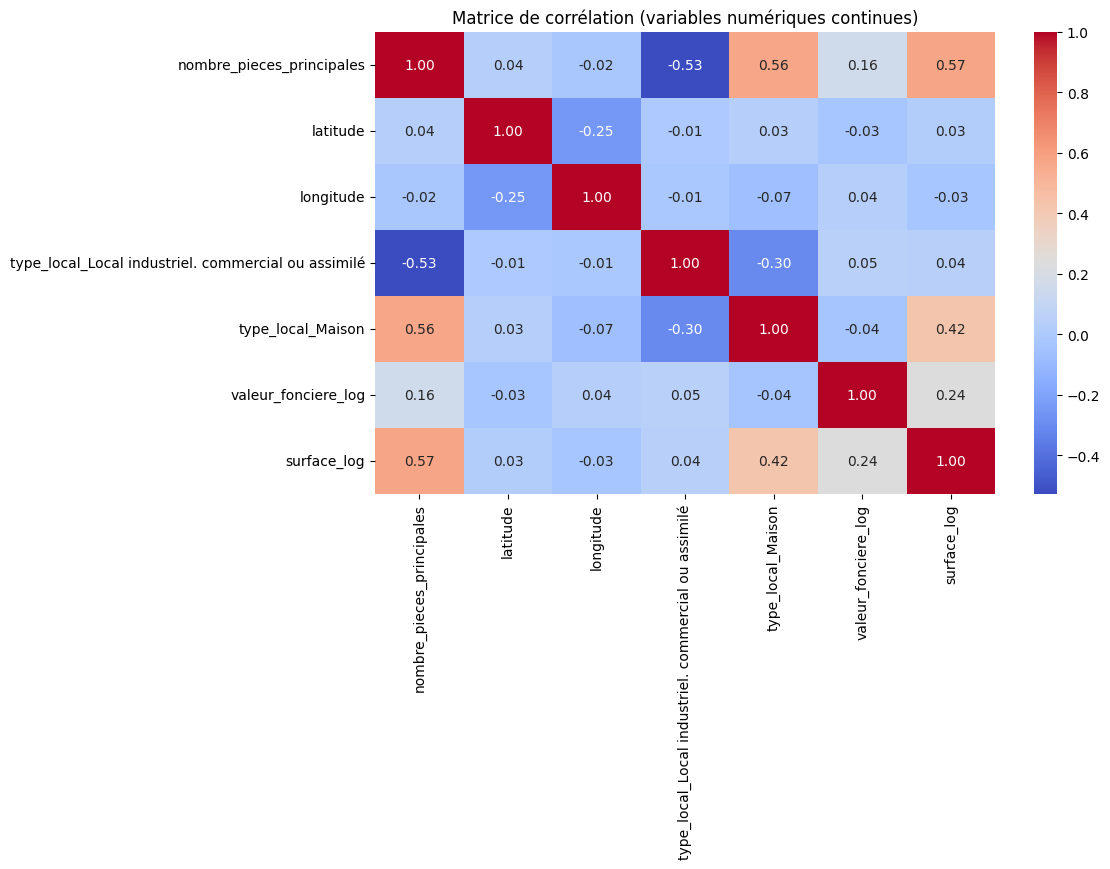

In [34]:
# Sélectionner les variables numériques
df_numeriques = df.drop(columns=['surface_reelle_bati','valeur_fonciere']).select_dtypes(include=['int64', 'float64'])

# Calcul de la matrice de corrélation
corr_matrix = df_numeriques.corr()

# Affichage avec une heatmap
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Matrice de corrélation (variables numériques continues)")
plt.show()


### Creation de la variable densite

In [39]:
df['densite_pieces'] = df['nombre_pieces_principales'] / df['surface_reelle_bati']

### Asymetrie des variables principales

<Axes: xlabel='valeur_fonciere', ylabel='Count'>

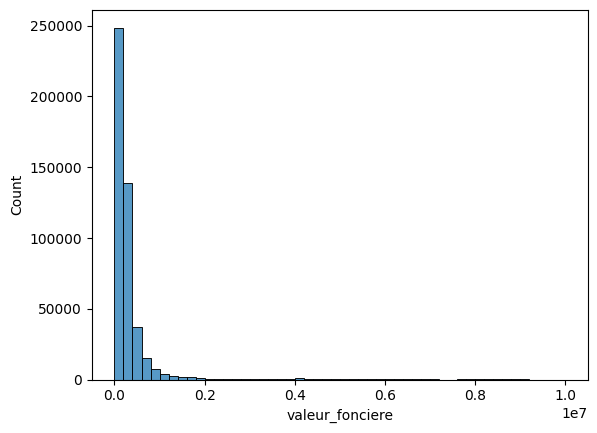

In [ ]:
df['valeur_fonciere'].describe()
sns.histplot(df['valeur_fonciere'], bins=50)

In [38]:
from scipy.stats import skew

# Calcul de l'asymétrie
asymetrie = skew(df['valeur_fonciere'])
print(f"Coefficient d'asymétrie (skewness) : {asymetrie:.2f}")

Coefficient d'asymétrie (skewness) : 7.17


<Axes: xlabel='surface_reelle_bati', ylabel='Count'>

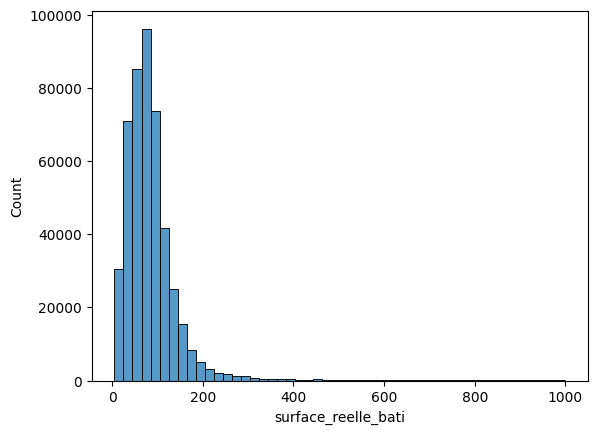

In [40]:
df['surface_reelle_bati'].describe()
sns.histplot(df['surface_reelle_bati'], bins=50)

In [41]:
from scipy.stats import skew

# Calcul de l'asymétrie
asymetrie = skew(df['surface_reelle_bati'])
print(f"Coefficient d'asymétrie (skewness) : {asymetrie:.2f}")

Coefficient d'asymétrie (skewness) : 5.18
